In [111]:
import numpy as np
import random
import heapq
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
class DisasterZoneEnv:
    """
    A 2D grid environment for a drone exploring a disaster zone.

    Legend (internally stored as integers):
        0 -> Empty cell
        1 -> Obstacle
        2 -> Survivor
        3 -> Resource

    'D' in a scenario array indicates the drone's starting position (only in predefined scenarios).
    """

    def __init__(
        self,
        width=8,
        height=8,
        num_obstacles=5,
        num_survivors=3,
        num_resources=2,
        initial_energy=20,
        dynamic=False,
        predefined_grid=None,
        seed=None,                # Optional random seed
        recharge_amount=None      # If None => full recharge upon resource, else partial
    ):
        self.width = width
        self.height = height
        self.num_obstacles = num_obstacles
        self.num_survivors = num_survivors
        self.num_resources = num_resources
        self.initial_energy = initial_energy
        self.energy = initial_energy
        self.dynamic = dynamic
        self.seed = seed
        self.recharge_amount = recharge_amount
        self.dynamic_changes = 0

        # Define possible actions - up, down, left, right
        self.action_space = {
            0: (-1, 0),  # up
            1: (1, 0),   # down
            2: (0, -1),  # left
            3: (0, 1)    # right
        }

        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        # If we have a predefined grid, load that; otherwise random layout
        if predefined_grid is not None:
            self.reset_with_scenario(predefined_grid)
        else:
            self.reset()

    def reset(self):
        """
        Create a random environment layout:
        - obstacles, survivors, resources randomly placed
        - random drone start
        """
        self.grid = np.zeros((self.height, self.width), dtype=int)

        # Place obstacles
        for _ in range(self.num_obstacles):
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 1

        # Place survivors
        for _ in range(self.num_survivors):
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 2

        # Place resources
        for _ in range(self.num_resources):
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 3

        # Random start for the drone
        self.drone_x, self.drone_y = self._get_random_empty_cell()
        self.energy = self.initial_energy

        return self._get_state()

    def reset_with_scenario(self, scenario):
        """
        Load a predefined grid that may contain 'D' for the drone start.
        Convert it into an integer grid internally.
        """
        scenario = np.array(scenario, dtype=object)
        self.height, self.width = scenario.shape

        self.grid = np.zeros((self.height, self.width), dtype=int)

        drone_positions = []

        for i in range(self.height):
            for j in range(self.width):
                val = scenario[i, j]
                if val == 'D':
                    drone_positions.append((i, j))
                    self.grid[i, j] = 0  # treat 'D' cell as empty
                else:
                    self.grid[i, j] = int(val)

        if len(drone_positions) != 1:
            raise ValueError("Scenario must contain exactly one 'D' for the drone's start.")
        self.drone_x, self.drone_y = drone_positions[0]
        self.energy = self.initial_energy

    def _get_random_empty_cell(self):
        while True:
            x = random.randint(0, self.height - 1)
            y = random.randint(0, self.width - 1)
            if self.grid[x, y] == 0:
                return x, y

    def _get_state(self):
        """
        Returns the current state, which includes:
        - Drone's position (x, y)
        - Drone's energy level
        - Information about the cells up, down, left, and right of the drone

        A* and Dijkstra can ignore self.around, but it is essential for Q-Learning
        """
        up = self.grid[self.drone_x - 1, self.drone_y] if self.drone_x > 0 else -1
        down = self.grid[self.drone_x + 1, self.drone_y] if self.drone_x < self.height - 1 else -1
        left = self.grid[self.drone_x, self.drone_y - 1] if self.drone_y > 0 else -1
        right = self.grid[self.drone_x, self.drone_y + 1] if self.drone_y < self.width - 1 else -1

    
        # Store surrounding information in a tuple
        self.around = (up, down, left, right)
    
        # Return the full state
        return (self.drone_x, self.drone_y, self.energy, self.around)


    def step(self, action):
        """
        Executes a step in the environment.
        """
        dx, dy = self.action_space[action]
        new_x = self.drone_x + dx
        new_y = self.drone_y + dy

        reward = 0
        done = False

        if not self._in_bounds(new_x, new_y):
            reward -= 10  # Penalty for trying to move out of bounds
        elif self.grid[new_x, new_y] == 1:  # Obstacle collision
            reward -= 10
        else:
            # Valid move
            self.drone_x, self.drone_y = new_x, new_y

            if self.grid[new_x, new_y] == 0:
                reward += 1  # Reward for moving to an empty cell
            elif self.grid[new_x, new_y] == 2:
                reward += 10  # Reward for rescuing a survivor
                self.grid[new_x, new_y] = 0  # Remove survivor
            elif self.grid[new_x, new_y] == 3:
                reward += 5  # Reward for collecting a resource
                self.energy += 5  # Add 5 energy when collecting a resource
                self.grid[new_x, new_y] = 0  # Remove resource

        # Energy cost per move
        self.energy -= 1
        reward -= 1  # Decrease reward for the energy spent moving

        if self.energy <= 0:
            done = True

        return self._get_state(), reward, done
    

    def _in_bounds(self, x, y):
        """Check if the position is within the grid boundaries."""
        return 0 <= x < self.height and 0 <= y < self.width
    
    
    def apply_dynamic_changes(self, step_count):
        """
        Example dynamic changes:
         - Add an obstacle every 5 steps
         - Move all survivors every 3 steps
        """
        if not self.dynamic:
            return

        # Add an obstacle every 5 steps
        if step_count > 0 and step_count % 5 == 0:
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 1
            self.dynamic_changes += 1

        # Move survivors every 3 steps
        if step_count > 0 and step_count % 3 == 0:
            survivor_positions = [
                (xx, yy) for xx in range(self.height)
                for yy in range(self.width)
                if self.grid[xx, yy] == 2
            ]
            for (sx, sy) in survivor_positions:
                self.grid[sx, sy] = 0
                nx, ny = self._get_random_empty_cell()
                self.grid[nx, ny] = 2

    def render(self):
        grid_copy = self.grid.astype(str)
        grid_copy[grid_copy == '0'] = '.'
        grid_copy[grid_copy == '1'] = '#'
        grid_copy[grid_copy == '2'] = 'S'
        grid_copy[grid_copy == '3'] = 'R'

        # Mark the drone location
        grid_copy[self.drone_x, self.drone_y] = 'D'

        for row in grid_copy:
            print(" ".join(row))
        print(f"Energy: {self.energy}\n")

In [113]:
class DijkstraAgent:
    """
    An agent using Dijkstra's algorithm for pathfinding.
    """

    def __init__(self, env):
        self.env = env
        self.steps_taken = 0
        self.survivors_rescued = 0
        self.resources_collected = 0

    def dijkstra_search(self, grid, start, goal):
        import heapq
        directions = [(-1,0), (1,0), (0,-1), (0,1)]
        pq = [(0, start)]  # (distance, position)
        distances = {start: 0}
        previous = {start: None}

        while pq:
            current_dist, current_pos = heapq.heappop(pq)
            if current_pos == goal:
                # Reconstruct path
                path = []
                while current_pos is not None:
                    path.append(current_pos)
                    current_pos = previous[current_pos]
                path.reverse()
                return path, current_dist

            for dx, dy in directions:
                nx = current_pos[0] + dx
                ny = current_pos[1] + dy
                if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1]:
                    # 1 => obstacle
                    if grid[nx, ny] != 1:
                        new_dist = current_dist + 1
                        if (nx, ny) not in distances or new_dist < distances[(nx, ny)]:
                            distances[(nx, ny)] = new_dist
                            previous[(nx, ny)] = current_pos
                            heapq.heappush(pq, (new_dist, (nx, ny)))

        return [], float('inf')

    def find_closest_target(self, target_type):
        """
        Find the path to the nearest cell with grid == target_type (2=Survivor or 3=Resource).
        """
        start = (self.env.drone_x, self.env.drone_y)
        targets = [
            (x, y) for x in range(self.env.height)
            for y in range(self.env.width)
            if self.env.grid[x, y] == target_type
        ]
        if not targets:
            return None, None, float('inf')

        best_path = None
        best_target = None
        best_dist = float('inf')

        for t in targets:
            path, dist = self.dijkstra_search(self.env.grid, start, t)
            if dist < best_dist:
                best_dist = dist
                best_path = path
                best_target = t

        return best_path, best_target, best_dist

    def execute(self):
        step_count = 0
        while self.env.energy > 0:
            # 1) look for survivors
            path, target_pos, _ = self.find_closest_target(2)
            if not path:
                # 2) then look for resources
                path, target_pos, _ = self.find_closest_target(3)

            if not path:
                print("No reachable targets. Stopping.")
                break

            # Move step by step
            for cell in path[1:]:
                self.env.drone_x, self.env.drone_y = cell
                self.steps_taken += 1
                step_count += 1

                # if environment is dynamic
                if self.env.dynamic:
                    self.env.apply_dynamic_changes(step_count)

                self.env.energy -= 1
                if self.env.energy <= 0:
                    break

            # If we actually reached a target
            if target_pos:
                cell_val = self.env.grid[target_pos[0], target_pos[1]]
                if cell_val == 2:
                    self.survivors_rescued += 1
                elif cell_val == 3:
                    self.resources_collected += 1
                # Mark empty
                self.env.grid[target_pos[0], target_pos[1]] = 0

In [123]:
class AStarDrone:
    def __init__(self, env, initial_position=None):
        self.env = env
        self.position = initial_position if initial_position else (self.env.drone_x, self.env.drone_y)
        self.energy = self.env.energy
        self.steps_taken = self.survivors_rescued = self.resources_collected = self.energy_used = 0
        
    def execute(self):
        while self.env.energy > 0:
            target = self.find_nearest_target()
            if not target:
                print("No reachable targets left. Ending mission.")
                return False

            next_move = self.a_star_search(self.position, target)
            if not next_move:
                print(f"Unable to proceed further at step {self.steps_taken}. Ending mission.")
                return False

            self.position = next_move
            self.steps_taken += 1
            self.env.energy -= 1
            self.energy_used += 1
            self.env.apply_dynamic_changes(self.steps_taken)

            current_cell = self.env.grid[self.position[0]][self.position[1]]
            if current_cell == 2:  # Rescue survivor
                self.survivors_rescued += 1
                self.env.grid[self.position[0]][self.position[1]] = 0
                print(f"Survivor rescued at {self.position}")
            elif current_cell == 3:  # Collect resource (recharge)
                self.resources_collected += 1
                self.env.grid[self.position[0]][self.position[1]] = 0
                self.env.energy = min(self.env.energy + 5, self.env.initial_energy)
                print(f"Recharged at {self.position}. Current energy: {self.env.energy}")
            self.env.drone_x, self.env.drone_y = self.position

    def find_nearest_target(self):
        targets = [(x, y) for x in range(self.env.height) for y in range(self.env.width) if self.env.grid[x][y] in [2, 3]]
        return min(targets, key=lambda t: self.heuristic(self.position, t)) if targets else None

    def a_star_search(self, start, goal):
        open_list, came_from, g_score, f_score, visited = [(0, start)], {}, {start: 0}, {start: self.heuristic(start, goal)}, set()
        while open_list:
            _, current = heapq.heappop(open_list)
            if current == goal: return self.reconstruct_path(came_from, current)

            visited.add(current)
            for neighbor in self.get_neighbors(current):
                if neighbor in visited or self.env.grid[neighbor[0]][neighbor[1]] == 1: continue
                tentative_g_score = g_score[current] + 1
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + self.heuristic(neighbor, goal)
                    heapq.heappush(open_list, (f_score[neighbor], neighbor))
        return None

    def get_neighbors(self, position):
        x, y = position
        return [(nx, ny) for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)] if 0 <= (nx := x + dx) < self.env.height and 0 <= (ny := y + dy) < self.env.width and self.env.grid[nx][ny] != 1]
    
    def heuristic(self, position, goal):
        return abs(position[0] - goal[0]) + abs(position[1] - goal[1])
    
    def reconstruct_path(self, came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.reverse()
        return path[0] if path else None

In [115]:
from collections import defaultdict

def initialize_q_table_dict(action_space):
    """
    Initializes a Q-table using a dictionary to handle large state spaces efficiently.
    :param action_space: The action space of the environment to determine the action space size.
    :return: A defaultdict for the Q-table.
    """
    return defaultdict(lambda: np.zeros(len(action_space)))

def compute_state_key(around):
    """
    Computes a unique state key based on the agent's surrounding grid.
    :param around: Tuple containing information about up, down, left, and right cells.
    :return: A hashable state key.
    """
    return tuple(around)

def q_learning_train_dict(env, q_table, episodes=10000, max_steps=100, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.996):
    """
    Q-learning training loop for an agent with a simplified state structure (based on surroundings only).
    Tracks average reward every 50,000 episodes and saves the Q-table.
    """
    total_rewards = []  # Store rewards per episode for analysis

    for episode in range(episodes):
        state = env.reset()  # Reset the environment for a new episode
        total_reward = 0
        step_count = 0  # Step counter for dynamic changes

        for step in range(max_steps):
            # Apply dynamic environment changes if applicable (before the agent perceives the state)
            if env.dynamic:
                env.apply_dynamic_changes(step_count)

            # Unpack the state after dynamic changes
            around = state[3]  # Only consider surroundings for the state key
            state_key = compute_state_key(around)  # State as a tuple for Q-table indexing

            # Choose action (epsilon-greedy)
            if np.random.random() < epsilon:
                action = np.random.choice(list(env.action_space.keys()))  # Exploration
            else:
                action = np.argmax(q_table[state_key])  # Exploitation

            # Take the action and observe the next state, reward, and whether the episode is done
            next_state, reward, done = env.step(action)

            # Unpack the next state
            next_around = next_state[3]
            next_state_key = compute_state_key(next_around)

            # Compute Q-values
            current_q = q_table[state_key][action]
            max_future_q = np.max(q_table[next_state_key])

            # Update Q-value using the Bellman equation
            q_table[state_key][action] = current_q + alpha * (reward + gamma * max_future_q - current_q)

            # Update the state and accumulate the total reward
            state = next_state
            total_reward += reward

            # Increment step counter for dynamic changes
            step_count += 1

            # Break if the episode is done
            if done:
                break

        # Decay epsilon
        epsilon = max(epsilon * epsilon_decay, 0.1)

        # Track rewards
        total_rewards.append(total_reward)

        # Print average reward every 50,000 episodes
        if (episode + 1) % 50000 == 0:
            avg_reward = np.mean(total_rewards[-50000:])
            print(f"Episode {episode + 1}/{episodes}: Average Reward (Last 50000 Episodes): {avg_reward:.2f}")

    return total_rewards

def test_pretrained_agent(env, q_table, max_steps=100):
    """
    Test the agent using a pre-trained Q-table for one episode, including dynamic changes.
    """
    state = env.reset()
    total_reward = 0
    step_count = 0  # Track steps for dynamic changes
    num_survivors = 0
    num_resources = 0

    print("\nTesting the agent:")
    env.render()

    for step in range(max_steps):
        # Unpack the state
        around = state[3]  # Only the surroundings are part of the state now
        state_key = compute_state_key(around)  # Adjusted to match the updated state key

        # Exploit the pre-trained Q-table
        if state_key in q_table:
            action = np.argmax(q_table[state_key])
            print(f"Q-Values: {q_table[state_key]}")
        else:
            # Fallback in case state is not in Q-table (shouldn't happen if trained well)
            action = np.random.choice(list(env.action_space.keys()))
            print("State not found in Q-table. Taking random action.")

        # Determine the target cell based on the action
        dx, dy = env.action_space[action]
        target_x = env.drone_x + dx
        target_y = env.drone_y + dy

        # Check if the target cell contains a survivor or resource
        if env._in_bounds(target_x, target_y):
            target_value = env.grid[target_x, target_y]
            if target_value == 2:  # Survivor
                num_survivors += 1
                print(f"Rescued a survivor at ({target_x}, {target_y})! Total survivors rescued: {num_survivors}")
            elif target_value == 3:  # Resource
                num_resources += 1
                print(f"Collected a resource at ({target_x}, {target_y})! Total resources collected: {num_resources}")

        # Take action and apply dynamic changes
        next_state, reward, done = env.step(action)
        env.apply_dynamic_changes(step_count)  # Apply dynamic environment changes if applicable

        print(f"\nStep {step + 1}:")
        print(f"Action Taken: {action} -> Moving to ({target_x}, {target_y})")
        print(f"Reward: {reward}")
        env.render()

        # Update state and accumulate reward
        state = next_state
        total_reward += reward

        # Increment step count for dynamic changes
        step_count += 1

        if done:
            print(f"\nEpisode finished after {step + 1} steps with total reward {total_reward}")
            break

    if not done:
        print(f"\nEpisode ended after {max_steps} steps with total reward {total_reward}")

    # Final Results
    print("\nFinal Results:")
    print(f"Total Reward: {total_reward}")
    print(f"Steps Taken: {step_count}")
    print(f"Total Survivors Rescued: {num_survivors}")
    print(f"Total Resources Collected: {num_resources}")

    return {
        "total_reward": total_reward,
        "steps_taken": step_count,
        "survivors_rescued": num_survivors,
        "resources_collected": num_resources,
    }

In [116]:
# In your main function:
if __name__ == "__main__":
    # Global variable to hold the Q-table
    q_table_global = None
    n = 300000

    # Initialize the environment and Q-table for training
    env_dynamic = DisasterZoneEnv(width=8, height=8, num_obstacles=5, num_survivors=5, num_resources=5, initial_energy=25, dynamic=True)
    env_static = DisasterZoneEnv(width=8, height=8, num_obstacles=5, num_survivors=5, num_resources=5, initial_energy=25, dynamic=False)
    
    # Initialize the Q-table (pass the action space size from the environment)
    q_table = initialize_q_table_dict(env_static.action_space)  # Use static env's action space

    # Train the agent in the static environment
    print("Training the Q-learning agent in the static environment...")
    static_rewards = q_learning_train_dict(env_static, q_table, episodes=n, max_steps=100)

    # Train the agent in the dynamic environment
    print("Training the Q-learning agent in the dynamic environment...")
    dynamic_rewards = q_learning_train_dict(env_dynamic, q_table, episodes=n, max_steps=100)

    # Store the trained Q-table in a global variable
    q_table_global = q_table

Training the Q-learning agent in the static environment...
Episode 50000/300000: Average Reward (Last 50000 Episodes): 13.92
Episode 100000/300000: Average Reward (Last 50000 Episodes): 14.62
Episode 150000/300000: Average Reward (Last 50000 Episodes): 14.51
Episode 200000/300000: Average Reward (Last 50000 Episodes): 14.76
Episode 250000/300000: Average Reward (Last 50000 Episodes): 14.53
Episode 300000/300000: Average Reward (Last 50000 Episodes): 14.75
Training the Q-learning agent in the dynamic environment...
Episode 50000/300000: Average Reward (Last 50000 Episodes): 29.17
Episode 100000/300000: Average Reward (Last 50000 Episodes): 29.39
Episode 150000/300000: Average Reward (Last 50000 Episodes): 29.58
Episode 200000/300000: Average Reward (Last 50000 Episodes): 29.42
Episode 250000/300000: Average Reward (Last 50000 Episodes): 29.45
Episode 300000/300000: Average Reward (Last 50000 Episodes): 29.51


In [117]:
class QLearningAgent:
    """
    An agent that uses a pre-trained Q-table to navigate the DisasterZoneEnv.
    """

    def __init__(self, env, q_table=None):
        self.env = env
        self.q_table = q_table if q_table else q_table_global  # Use the provided Q-table or global variable
        self.steps_taken = 0
        self.survivors_rescued = 0
        self.resources_collected = 0

    def execute(self):
        """
        Executes the agent in the given environment using the pre-trained Q-table.
        """
        state = self.env.reset()
        self.steps_taken = 0
        self.survivors_rescued = 0
        self.resources_collected = 0

        for step in range(self.env.initial_energy):
            # Unpack state
            energy, around = state[2], state[3]
            state_key = tuple(around)  # The state key does not use energy

            # Decide action based on Q-table
            if state_key in self.q_table:
                action = np.argmax(self.q_table[state_key])
            else:
                # Fallback to random action if state is unknown
                action = np.random.choice(list(self.env.action_space.keys()))

            # Determine target cell
            dx, dy = self.env.action_space[action]
            target_x = self.env.drone_x + dx
            target_y = self.env.drone_y + dy

            # Check the cell content
            if self.env._in_bounds(target_x, target_y):
                target_value = self.env.grid[target_x, target_y]
                if target_value == 2:  # Survivor
                    self.survivors_rescued += 1
                elif target_value == 3:  # Resource
                    self.resources_collected += 1

            # Take action
            next_state, _, done = self.env.step(action)

            # Update state and step count
            state = next_state
            self.steps_taken += 1

            # Handle dynamic environment changes
            if self.env.dynamic:
                self.env.apply_dynamic_changes(self.steps_taken)

            if done:
                break

In [118]:
# Cell 4: Scenarios Dictionary

SCENARIOS_DICT = {
    "Scenario_1": {
        "name": "Simple Layout",
        "grid": np.array([
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 2, 0, 1, 0, 0, 3, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [3, 0, 0, 0, 0, 0, 0, 'D']
        ], dtype=object),
        "dynamic": False,
        "description": "Minimal obstacles, static environment"
    },
    "Scenario_2": {
        "name": "Obstacle Maze",
        "grid": np.array([
            [0, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 2, 1, 0, 1, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 0],
            [0, 0, 0, 1, 0, 1, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 3],
            [0, 1, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0, 0, 2, 0],
            ['D', 1, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": False,
        "description": "A more complex layout"
    },
    "Scenario_3": {
        "name": "Dynamic Mixed Layout",
        "grid": np.array([
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 3, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 2, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 3, 0, 0, 0, 0],
            ['D', 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": True,
        "description": "Dynamic environment with obstacles and survivors moving"
    },

    # Larger 12x12 static
    "Scenario_4": {
        "name": "Large 12x12 Static",
        "grid": np.array([
            [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
            [0, 2, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0],
            [1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1],
            [0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 3, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [3, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 1, 3, 0, 2, 0, 0],
            ['D', 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": False,
        "description": "A bigger static scenario with more obstacles, survivors, resources"
    },

    # Larger 12x12 dynamic
    "Scenario_5": {
        "name": "Large 12x12 Dynamic",
        "grid": np.array([
            [0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0],
            [0, 2, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0],
            [1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1],
            [0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 3, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [3, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 1, 3, 0, 2, 0, 0],
            ['D', 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": True,
        "description": "A bigger dynamic scenario for differences between A* and Dijkstra"
    },
}

In [119]:
# Cell 5: Tester

class Tester:
    """
    Runs multiple agents on multiple scenarios, collects metrics into a results table.
    """

    def __init__(self, agent_classes, scenarios_dict, env_params=None):
        self.agent_classes = agent_classes
        self.scenarios_dict = scenarios_dict
        self.env_params = env_params if env_params else {}
        self.results = []

    def run_all_scenarios(self):
        for scenario_id, scenario_info in self.scenarios_dict.items():
            scenario_grid = scenario_info["grid"]
            scenario_name = scenario_info.get("name", scenario_id)
            scenario_dynamic = scenario_info.get("dynamic", False)
            scenario_desc = scenario_info.get("description", "")

            # Merge scenario-level dynamic with global env_params
            # i.e., if scenario_dynamic is True, we override env_params' dynamic
            param_dynamic = scenario_dynamic or self.env_params.get("dynamic", False)
            param_initial_energy = scenario_info.get("initial_energy", self.env_params.get("initial_energy", 20))

            # Optionally override other parameters if needed (like num_obstacles, seed, etc.)
            # but for now we just keep global env_params for these

            for agent_class in self.agent_classes:
                # Create environment
                env = DisasterZoneEnv(
                    width=self.env_params.get("width", 8),
                    height=self.env_params.get("height", 8),
                    num_obstacles=self.env_params.get("num_obstacles", 5),
                    num_survivors=self.env_params.get("num_survivors", 3),
                    num_resources=self.env_params.get("num_resources", 2),
                    initial_energy=param_initial_energy,
                    dynamic=param_dynamic,
                    predefined_grid=scenario_grid,
                    seed=self.env_params.get("seed", None),
                    recharge_amount=self.env_params.get("recharge_amount", None)
                )

                # Instantiate agent
                agent = agent_class(env)
                
             
                start_time = time.perf_counter()
                agent.execute()
                end_time = time.perf_counter()
                comp_time = end_time - start_time

                # Collect results
                self.results.append({
                    "Scenario ID": scenario_id,
                    "Scenario Name": scenario_name,
                    "Description": scenario_desc,
                    "Is Dynamic": param_dynamic,
                    "Agent Name": agent_class.__name__,
                    "Steps Taken": getattr(agent, "steps_taken", None),
                    "Survivors Rescued": getattr(agent, "survivors_rescued", None),
                    "Resources Collected": getattr(agent, "resources_collected", None),
                    "Energy Used": param_initial_energy - env.energy,
                    "Computation Time (s)": comp_time
                })

    def get_results_df(self):
        return pd.DataFrame(self.results)

    def save_results(self, filename="results.csv"):
        df = pd.DataFrame(self.results)
        df.to_csv(filename, index=False)
        print(f"Results saved to {filename}")

In [129]:
# Cell 6: Example Execution

# We'll compare Dijkstra and AStar on all scenarios
agent_list = [DijkstraAgent, AStarDrone, QLearningAgent]

# We'll test them with these default environment params
env_params = {
    "width": 12,           # We'll force a 12x12 grid for all, but scenario_1,2,3 are actually 8x8
                           # The scenario's shape actually overrides this for predefined grids, but that's okay.
    "height": 12,
    "num_obstacles": 5,    # For random scenario usage only
    "num_survivors": 3,
    "num_resources": 2,
    "initial_energy": 25,  # Slightly higher energy to handle bigger grids
    "dynamic": False,      # We'll rely on scenario dict for dynamic= True or False
    "seed": 42             # Reproducible
}

# Instantiate the tester
tester = Tester(agent_classes=agent_list, scenarios_dict=SCENARIOS_DICT, env_params=env_params)

# Run all scenarios
tester.run_all_scenarios()

# Get results as DataFrame
df_results = tester.get_results_df()
print(df_results)

# Optionally save
tester.save_results("results_comparison.csv")

Survivor rescued at (6, 5)
Recharged at (2, 6). Current energy: 22
Survivor rescued at (2, 1)
Recharged at (7, 0). Current energy: 12
No reachable targets left. Ending mission.
No reachable targets. Stopping.
Survivor rescued at (1, 2)
Survivor rescued at (6, 6)
Recharged at (4, 7). Current energy: 10
No reachable targets left. Ending mission.
Recharged at (6, 3). Current energy: 25
Recharged at (2, 4). Current energy: 25
Survivor rescued at (3, 3)
Survivor rescued at (3, 5)
No reachable targets left. Ending mission.
Recharged at (7, 0). Current energy: 25
Survivor rescued at (5, 4)
Recharged at (3, 4). Current energy: 22
Recharged at (0, 5). Current energy: 23
Survivor rescued at (1, 1)
Recharged at (1, 9). Current energy: 13
Survivor rescued at (2, 8)
Recharged at (5, 7). Current energy: 10
Survivor rescued at (7, 8)
Recharged at (8, 6). Current energy: 9
Recharged at (10, 7). Current energy: 11
Survivor rescued at (10, 9)
No reachable targets left. Ending mission.
Recharged at (7, 0

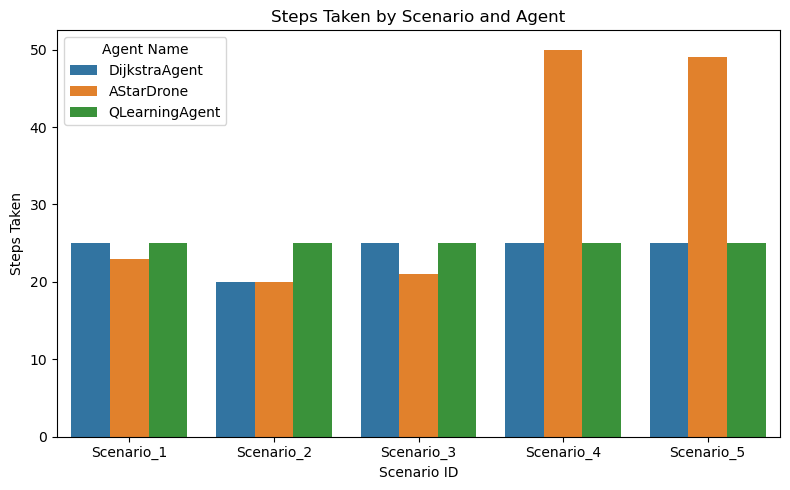

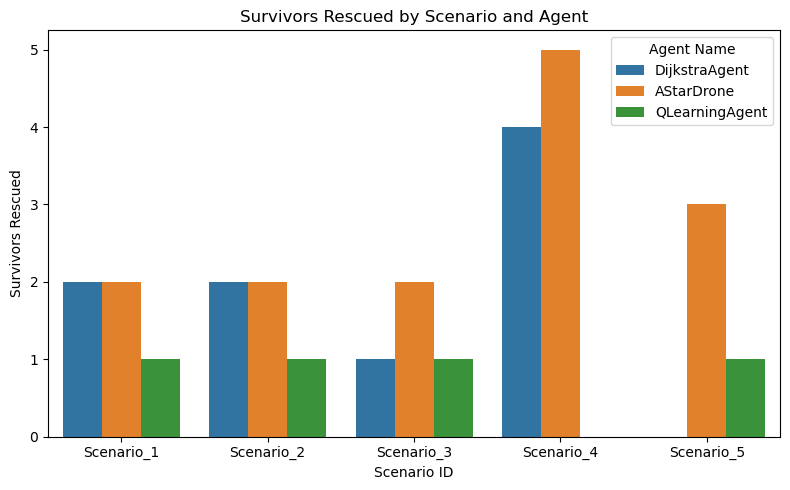

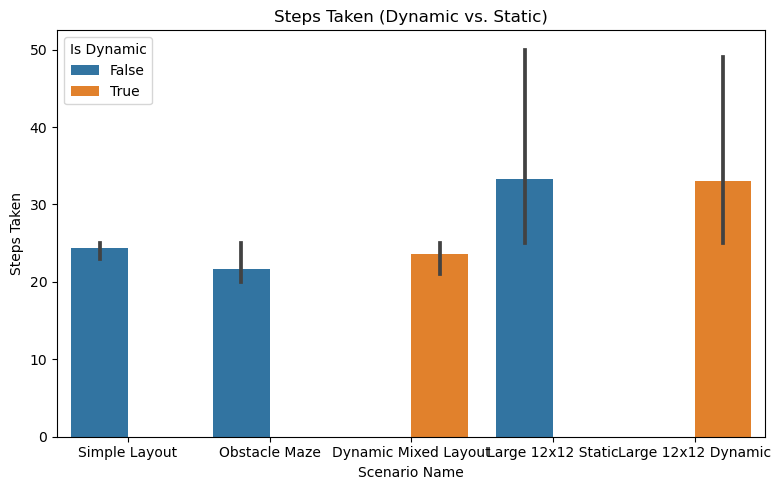

In [130]:
df = df_results  # for convenience

# 1) Basic bar plot of "Steps Taken"
plt.figure(figsize=(8,5))
sns.barplot(data=df, x="Scenario ID", y="Steps Taken", hue="Agent Name")
plt.title("Steps Taken by Scenario and Agent")
plt.tight_layout()
plt.show()

# 2) Survivors Rescued
plt.figure(figsize=(8,5))
sns.barplot(data=df, x="Scenario ID", y="Survivors Rescued", hue="Agent Name")
plt.title("Survivors Rescued by Scenario and Agent")
plt.tight_layout()
plt.show()

# 3) If you want to see how dynamic vs static differ, you can do e.g.:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x="Scenario Name", y="Steps Taken", hue="Is Dynamic")
plt.title("Steps Taken (Dynamic vs. Static)")
plt.tight_layout()
plt.show()